In [1]:
base_path = "../soc-viz-of-the-week/assets"

In [2]:
import ScraperFC as sfc
import matplotlib.pyplot as plt

scr = sfc.Understat()
try:
    lg = scr.scrape_league_table(2023, "Serie A")
except:
    import traceback
    
    trackeback.print_exc()
finally:
    scr.close()

[WDM] - Downloading: 100%|████████████████████████████████████████████████████████| 6.80M/6.80M [00:00<00:00, 8.77MB/s]


In [3]:
data = lg[["Team", "PTS", "xPTS"]]

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
from highlight_text import fig_text, ax_text
from adjustText import adjust_text
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib import cm
import scipy.stats as stats


from mplsoccer import Pitch

from PIL import Image
import urllib
import os

font_path = base_path + "/fonts"
for x in os.listdir(font_path):
    for y in os.listdir(f"{font_path}/{x}"):
        if y.split(".")[-1] == "ttf":
            fm.fontManager.addfont(f"{font_path}/{x}/{y}")
            try:
                fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y.split("-")[0])
            except Exception:
                continue

plt.style.use(base_path + "/stylesheets/soc_base.mplstyle")
plt.rcParams['font.family'] = 'Karla'

'\nplt.savefig(\n\t"figures/11072022_long_balls.png",\n\tdpi = 600,\n\tfacecolor = "#EFE9E6",\n\tbbox_inches="tight",\n    edgecolor="none",\n\ttransparent = False\n)\n\nplt.savefig(\n\t"figures/11072022_long_balls_tr.png",\n\tdpi = 600,\n\tfacecolor = "none",\n\tbbox_inches="tight",\n    edgecolor="none",\n\ttransparent = True\n)'

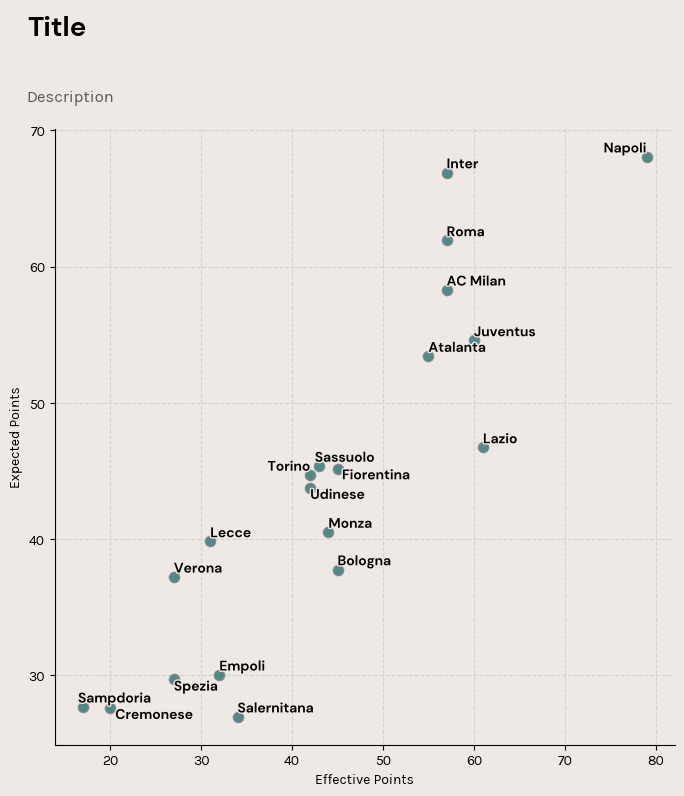

In [10]:
fig = plt.figure(figsize=(8,8), dpi=100)
ax = plt.subplot()
ax.grid(visible=True, ls='--', color='lightgrey')

ax.scatter(
    data.PTS, data.xPTS, cmap='inferno', 
    zorder=3, ec='grey', s=55, alpha=0.8)
    
texts = []
for index in range(0, len(data)):
    texts += [
        ax.text(
            x=data.PTS.iloc[index], y=data.xPTS.iloc[index],
            s=data.Team.iloc[index],
            path_effects=[path_effects.Stroke(linewidth=2, foreground=fig.get_facecolor()), 
            path_effects.Normal()], color='black',
            family='DM Sans', weight='bold'
        )
    ]

adjust_text(texts, only_move={'points':'y', 'text':'xy', 'objects':'xy'})

#ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
#ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0%}'))
#ax.set_xlim(0)
#ax.set_ylim(0,1)

ax.set_ylabel('Expected Points')
ax.set_xlabel('Effective Points')

fig_text(
    x = 0.09, y = .99, 
    s = "Title",
    va = "bottom", ha = "left",
    fontsize = 20, color = "black", font = "DM Sans", weight = "bold"
)

fig_text(
    x = 0.09, y = 0.91, 
    s = "Description",
    va = "bottom", ha = "left",
    fontsize = 12, color = "#5A5A5A", font = "Karla"
)

'''
plt.savefig(
	"figures/11072022_long_balls.png",
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)

plt.savefig(
	"figures/11072022_long_balls_tr.png",
	dpi = 600,
	facecolor = "none",
	bbox_inches="tight",
    edgecolor="none",
	transparent = True
)'''


<Axes: ylabel='Team'>

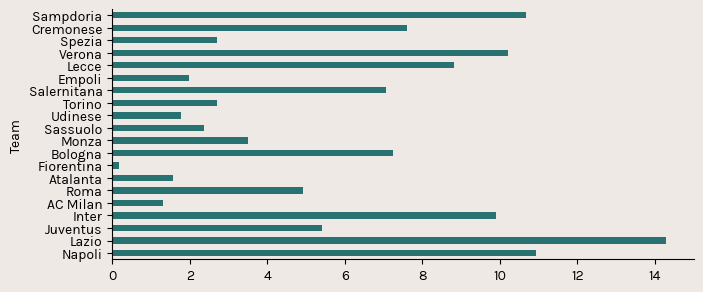

In [6]:
pts = data.set_index(data.Team)["PTS"]
xpts = data.set_index(data.Team)["xPTS"]
diff = pts.sub(xpts).abs().astype("float64").round(2)
diff.plot.barh()

In [7]:
space = diff.max() / 3
bins = np.arange(0, diff.max(), diff.max()/3)
bins

array([0.  , 4.76, 9.52])

In [8]:
data[data["Team"] == "Napoli"]

,Team,PTS,xPTS
0,Napoli,79,68.07
